# 4_SHAP_Explainability.ipynb – DNN & CNN Models

In this notebook, I’ll use SHAP to explain the predictions of both the DNN and CNN models using **tabular input only**. For each model, I will generate global and local SHAP plots to understand which features contributed most to their predictions.

Text input (BERT) is excluded from this SHAP analysis to focus purely on structured/tabular features, allowing clearer insights into how financial variables like loan amount, interest rate, and credit scores impact approval decisions.

# (DNN SHAP) - Step 1: Load Dataset, Preprocess Tabular Input, and Sample 300 Rows

First, I’ll load the sampled LendingClub dataset and use the same preprocessor that was fitted during DNN training. I’ll apply it to a random sample of 300 rows, which I’ll use for SHAP explanation. This allows for more meaningful feature insights in the global SHAP plot.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import shap
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

df = pd.read_csv('/content/drive/MyDrive/LoanApprovalProject/Data/loan_data_sampled.csv')
X_tabular = df.drop(['loan_status', 'text'], axis=1)
y = df['loan_status']

# Sample 300 rows for SHAP
sample_idx = np.random.RandomState(42).choice(len(X_tabular), size=300, replace=False)
X_sample = X_tabular.iloc[sample_idx]
y_sample = y.iloc[sample_idx]

# Load saved preprocessor and transform sample
preprocessor = joblib.load('/content/drive/MyDrive/LoanApprovalProject/Code/dnn_preprocessor.joblib')
X_sample_processed = preprocessor.transform(X_sample)
X_dense = X_sample_processed.toarray() if hasattr(X_sample_processed, 'toarray') else X_sample_processed

# Feature name extraction (numerical + categorical)
categorical_cols = ['term', 'grade', 'emp_title', 'home_ownership', 'verification_status']
numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util', 'fico_range_high']

num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numerical_cols)
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_features, cat_features])

input_shape = X_dense.shape[1]

# Build simple tabular-only model (same as original DNN branch)
tab_input = Input(shape=(input_shape,), name="tabular_input")
x = Dense(64, activation='relu')(tab_input)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
tabular_model = Model(inputs=tab_input, outputs=output)

# Warm up the model once to avoid SHAP eager mode bug
_ = tabular_model.predict(X_dense[:1])

Mounted at /content/drive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


# Step 2: Compute SHAP Values using DeepExplainer

I’ll now use SHAP’s DeepExplainer to compute the contribution of each tabular feature to the model's output. The background set is the first 50 rows, and the explanation is performed on 300 samples. These SHAP values will be used to generate both global and local interpretability plots.

In [2]:
# Create SHAP DeepExplainer using 50 background rows
explainer = shap.DeepExplainer(tabular_model, X_dense[:50])

# Compute SHAP values on 300 sample rows
shap_values = explainer.shap_values(X_dense[:300])

# Confirm shape
print(" SHAP value shape (expected [300, features]):", shap_values.shape)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tabular_input
Received: inputs=['Tensor(shape=(50, 6429))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tabular_input
Received: inputs=['Tensor(shape=(100, 6429))']
  warnings.warn(msg)


 SHAP value shape (expected [300, features]): (300, 6429, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tabular_input
Received: inputs=['Tensor(shape=(300, 6429))']
  warnings.warn(msg)


# Step 3: SHAP Global Feature Importance Plot

This SHAP summary bar plot shows the most important tabular features that influenced predictions across 300 samples. Features are ranked by their average absolute SHAP values.

 SHAP bar chart saved.


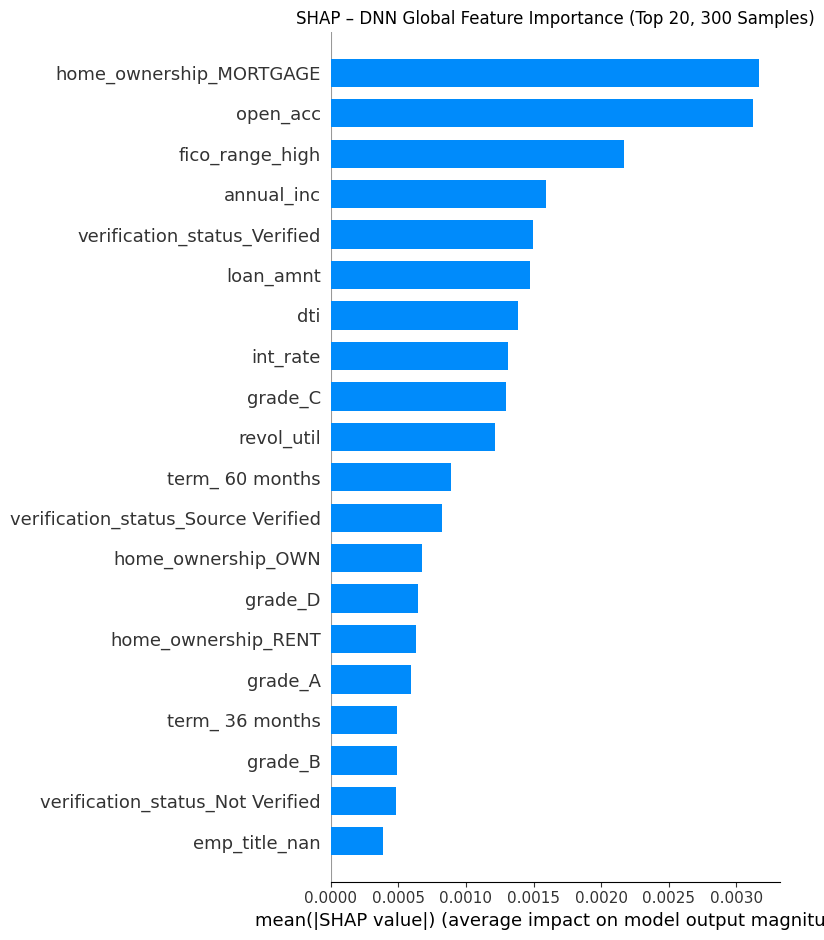

In [3]:
# Convert SHAP output shape from (300, 6429, 1) to (300, 6429)
shap_values_2d = shap_values.squeeze(axis=-1)

# Plot and save summary
shap.initjs()
plt.figure()
shap.summary_plot(
    shap_values_2d,
    X_dense[:300],
    feature_names=feature_names,
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title("SHAP – DNN Global Feature Importance (Top 20, 300 Samples)")
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/LoanApprovalProject/Figures/shap_dnn_global_top20_300samples.png')
print(" SHAP bar chart saved.")

###  DNN SHAP — Global Feature Importance (Top 20)

This summary bar plot highlights the top tabular features influencing the DNN model across 300 samples.

- **Top contributors** are `home_ownership_MORTGAGE`, `open_acc`, and `fico_range_high`.
- Important **numerical features** include `annual_inc`, `loan_amnt`, `int_rate`, and `dti`.
- **Categorical encodings** like `verification_status_Verified`, `grade_C`, and `home_ownership_RENT` also contributed significantly.

These results suggest the DNN model captures a wide variety of signals from both financial indicators and encoded categories, supporting a balanced and interpretable decision process.

## Step 4: Local Explanation for a Single Prediction (DNN)

To complement the global SHAP analysis, we can now inspect **local explanations** for individual predictions. These show how each feature impacted the model's decision for a specific instance — helping to understand _why_ the model predicted a certain outcome.

This is useful in practical deployment when justifying or reviewing individual loan decisions.

In [4]:
# Choose instance
instance_idx = 0

# prepare inputs
instance_shap_values = shap_values[instance_idx].flatten()
instance_features = X_dense[instance_idx].flatten()
base_value = float(explainer.expected_value[0])

# Plot
shap.initjs()
shap.force_plot(
    base_value=base_value,
    shap_values=instance_shap_values,
    features=instance_features,
    feature_names=feature_names
)


###  DNN – Local SHAP Force Plot (Single Prediction)

This force plot explains how each tabular feature affected one individual prediction by the DNN model (predicted score ≈ **0.51**).

- **Pushing the score higher** (toward **approval**):
  - `verification_status_Verified = 0` (unverified income)
  - `dti = -0.7203` (lower DTI)
  - `int_rate = -1.034` (lower interest rate)
  - `home_ownership_RENT = 1` (renter)
  - `grade_C = 0`
  - `open_acc = -0.8682` (fewer open accounts)
  - `annual_inc = 0.9587` (higher income)
  - `fico_range_high = 0.8138` (strong credit score)

- **Pushing the score lower** (toward **rejection**):
  - `home_ownership_MORTGAGE = 0` (does not have a mortgage)
  - `loan_amnt = -0.8232` (smaller loan amount)
  - `grade_A = 1`
  - `emp_title_Foreman = 1` (occupation flag)

The model slightly leaned toward approval. It interpreted unverified income, renting, high income, and strong credit as positive signals, even though some conventional positives like home ownership and employment slightly reduced the predicted probability.

# (CNN SHAP) - Step 1: Load and Prepare Tabular Input

In this step, we load the preprocessed tabular dataset and select a sample of 300 rows for SHAP analysis.  
We use the same preprocessing pipeline applied during CNN training to ensure input consistency.  
Feature names are extracted to label SHAP values later. This setup allows us to analyze how individual tabular features influence the CNN model’s predictions.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import shap
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

df = pd.read_csv('/content/drive/MyDrive/LoanApprovalProject/Data/loan_data_sampled.csv')
X_tabular = df.drop(['loan_status', 'text'], axis=1)
y = df['loan_status']

# Sample 300 rows for SHAP
sample_idx = np.random.RandomState(42).choice(len(X_tabular), size=300, replace=False)
X_sample = X_tabular.iloc[sample_idx]
y_sample = y.iloc[sample_idx]

# Load CNN preprocessor
preprocessor = joblib.load('/content/drive/MyDrive/LoanApprovalProject/Code/cnn_preprocessor.joblib')
X_sample_processed = preprocessor.transform(X_sample)
X_dense = X_sample_processed.toarray() if hasattr(X_sample_processed, 'toarray') else X_sample_processed
X_dense = np.array(X_dense, dtype=np.float32)

# Get feature names
categorical_cols = ['term', 'grade', 'emp_title', 'home_ownership', 'verification_status']
numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util', 'fico_range_high']
num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numerical_cols)
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_features, cat_features])

print(" CNN sample processed:", X_dense.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 CNN sample processed: (300, 6429)


### Step 2: Build Simple CNN Model for SHAP

In this step, we build a standalone CNN model for SHAP analysis that mirrors the architecture used during training.  
This CNN processes structured/tabular data using Conv1D layers and is designed solely for explanation purposes.

To ensure compatibility with SHAP, we replace pooling layers (which disrupt feature-wise attribution) with a `Flatten` layer.  
This preserves the one-to-one relationship between input features and model activations, allowing SHAP to attribute importance directly to tabular inputs.

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout
import numpy as np

#  Reshape tabular input for Conv1D
X_reshaped = X_dense.reshape((X_dense.shape[0], X_dense.shape[1], 1))  # (300, 6429, 1)
input_shape = X_reshaped.shape[1:]

#  Build SHAP-compatible CNN model
tab_input = Input(shape=input_shape, name="tabular_input")
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(tab_input)
x = Flatten()(x)  # replace pooling with Flatten for SHAP compatibility
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

cnn_tabular_model = Model(inputs=tab_input, outputs=output)
print(" Flatten-based CNN model built.")

 Flatten-based CNN model built.


### Step 3: Compute SHAP Values (CNN – Tabular Model)

Now that our standalone CNN model is built, we use SHAP’s `DeepExplainer` to compute global feature attributions.  
These values help us understand which features in the tabular input contribute most to the CNN’s predictions.

We use 50 samples as a background reference set and generate SHAP values for 300 randomly sampled instances.

In [8]:
import shap

#  Warm-up pass to initialize model
_ = cnn_tabular_model.predict(X_reshaped[:1])

#  SHAP DeepExplainer
explainer = shap.DeepExplainer(cnn_tabular_model, X_reshaped[:50])
shap_values = explainer.shap_values(X_reshaped[:300].astype(np.float32))
#  Confirm shape
print(" SHAP value shape:", np.array(shap_values[0]).shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tabular_input
Received: inputs=['Tensor(shape=(50, 6429, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tabular_input
Received: inputs=['Tensor(shape=(100, 6429, 1))']
  warnings.warn(msg)


 SHAP value shape: (6429, 1, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tabular_input
Received: inputs=['Tensor(shape=(300, 6429, 1))']
  warnings.warn(msg)


### Step 4: Global SHAP Summary Plot (CNN – Top 20 Features)

To visualize the global importance of tabular features in the CNN model, we use SHAP’s summary bar plot.  
This chart shows the top 20 features ranked by average absolute SHAP value, helping us identify the most influential inputs.

We also save the plot into the `/Figures/` directory for use in the report and poster.

 CNN SHAP bar chart saved.


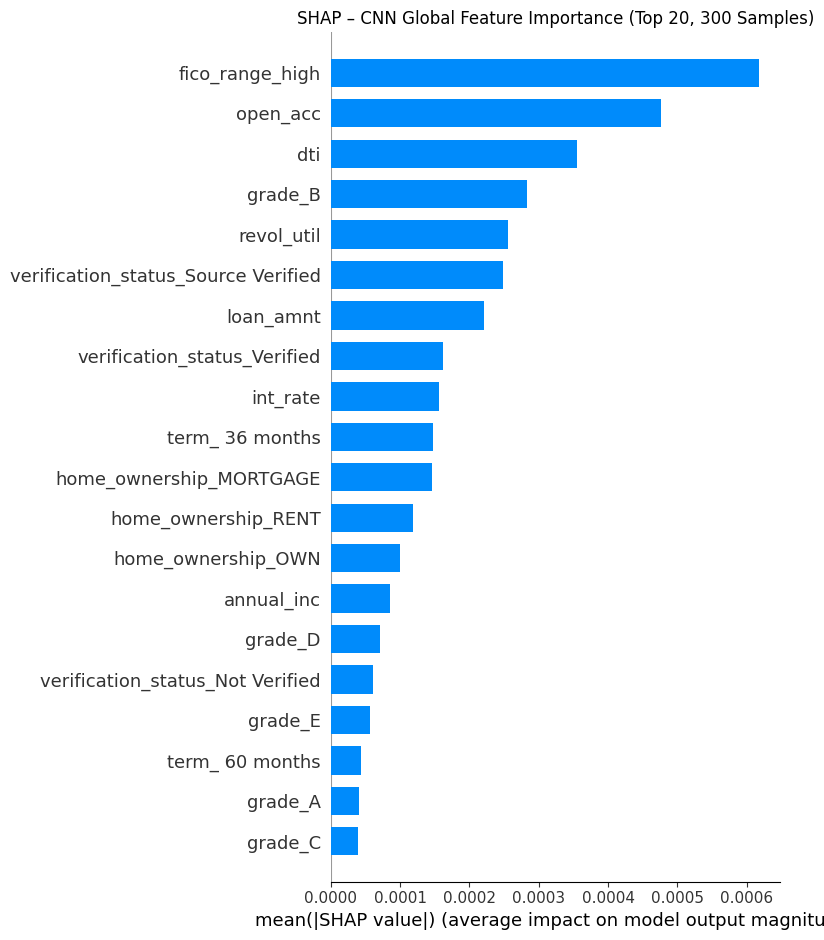

In [9]:
#  Convert SHAP values from (300, 6429, 1) to (300, 6429)
shap_values_2d = shap_values.squeeze()
#  Create summary bar plot
shap.initjs()
plt.figure()
shap.summary_plot(
    shap_values_2d,
    X_dense[:300],
    feature_names=feature_names,
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title("SHAP – CNN Global Feature Importance (Top 20, 300 Samples)")
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/LoanApprovalProject/Figures/shap_cnn_global_top20_300samples.png')
print(" CNN SHAP bar chart saved.")

###  CNN SHAP — Global Feature Importance (Top 20)

This SHAP summary highlights the most influential tabular features for the CNN model across 300 samples.

- Top contributors include `fico_range_high`, `open_acc`, and `dti`.
- Other notable features: `grade_B`, `revol_util`, and `verification_status_Source Verified`.
- Income-related features like `annual_inc` and `int_rate` ranked lower than in the DNN.
- CNN places more emphasis on individual categorical encodings (e.g. `grade_B`, `term_36 months`).

Unlike the DNN, which spreads attention more broadly, the CNN model seems to rely on fewer but more dominant features — possibly reflecting how convolutional filters extract sharper local patterns.

### Local SHAP Explanation – Force Plot (CNN Tabular)

To understand how individual predictions are made, we’ll generate a local SHAP force plot for one sample from the 300-row test set.  
This lets us see which features pushed the prediction higher (toward approval) or lower (toward rejection).

This level of transparency is key in financial settings where decisions need to be explainable.

In [10]:
# Choose instance
instance_idx = 0

# Fix and convert inputs
instance_shap_values = shap_values[instance_idx].flatten()               # (6429,)
instance_features     = X_dense[instance_idx].flatten().astype(float)    # (6429,)
base_value            = float(explainer.expected_value[0])               # scalar

# Visualize force plot using SHAP JS (tabular mode)
shap.initjs()
shap.force_plot(
    base_value=base_value,
    shap_values=instance_shap_values,
    features=instance_features,
    feature_names=feature_names
)

###  CNN SHAP – Local Force Plot (Single Prediction)

This force plot visualizes how the CNN model arrived at a prediction score of approximately **0.50** for a single test sample.  
Each feature either pushed the score **higher (red)** or **lower (blue)** depending on its contribution.

- **Pushing the score higher** (toward loan approval):
  - `home_ownership_MORTGAGE = 0` (not having a mortgage)
  - `revol_util = 0.685` (moderate revolving credit usage)
  - `verification_status_Verified = 0` (absence of verification)
  - `fico_range_high = 0.8138` (strong credit score)
  - `emp_title_Foreman = 1` (occupation category)

- **Pushing the score lower** (toward loan rejection):
  - Fewer open credit lines (`open_acc = -0.8682`)
  - Higher debt-to-income ratio (`dti = -0.7203`)
  - Verified income (`verification_status_Source Verified = 1`)
  - `grade_B = 0` (may signal higher risk than expected)
  - Shorter loan term (`term_36 months = 1`)


### Step 6: Save SHAP Outputs

In this final step, we save the CNN model’s SHAP plots both global and local for inclusion in the report and poster.  
These visualizations provide clear insight into how our model makes decisions using structured loan data.


In [11]:
import joblib
import numpy as np

# Save global SHAP values (DNN)
np.save('/content/drive/MyDrive/LoanApprovalProject/Code/shap_dnn_global.npy', shap_values_2d)

# Save feature names
joblib.dump(feature_names, '/content/drive/MyDrive/LoanApprovalProject/Code/shap_feature_names.pkl')

print(" DNN SHAP values and feature names saved.")


# Save global SHAP values (CNN)
np.save('/content/drive/MyDrive/LoanApprovalProject/Code/shap_cnn_global.npy', shap_values_2d)


print(" CNN SHAP values saved.")

 DNN SHAP values and feature names saved.
 CNN SHAP values saved.


##  Step 6: Conclusion — SHAP Explainability

- **Global Analysis**: Both models emphasized key financial indicators such as `fico_range_high`, `open_acc`, and `dti`. However, the CNN concentrated its attention more sharply on fewer features, while the DNN distributed importance more evenly.
- **Local Analysis**: SHAP force plots offered human interpretable justifications for individual predictions showing how features pushed outcomes toward approval or rejection.

These explainability results strengthen transparency and build trust in our model decisions, which is critical in high-stakes domains like loan approval.

While the **CNN** captured more nuanced interactions through convolutional layers, the **DNN** offered cleaner and more balanced interpretability.

This concludes the SHAP explainability phase of our project.